In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

import flygym.common
import flygym.mujoco
import flygym.mujoco.preprogrammed

Let's define some simulation parameters:

In [2]:
sim_params = flygym.mujoco.Parameters(
    timestep=1e-5, render_mode="saved", render_playspeed=0.01, draw_contacts=False, render_camera="Animat/camera_left"
)
actuated_joints = flygym.mujoco.preprogrammed.all_leg_dofs

We can now load recorded kinematics that are included with the FlyGym package:

In [3]:
def format_seqikpy_data(data, corresp_dict={"ThC": "Coxa",
                                             "CTr": "Femur",
                                               "FTi": "Tibia",
                                                 "TiTa": "Tarsus1"}
                                                 ):

    data_gym = {}
    for joint, values in data.items():
        if joint == "meta":
            data_gym[joint] = values
        else:
            leg = joint[6:8]
            joint_name = joint[9:]
            seg, dof = joint_name.split("_")
            if dof == "pitch":
                newjoint = f"joint_{leg}{corresp_dict[seg]}"
            else:
                newjoint = f"joint_{leg}{corresp_dict[seg]}_{dof}"

            data_gym[newjoint] = values


    return data_gym

seq_ikpy_data_path = Path("data/seqikpy_output/leg_joint_angles.pkl")
with open(seq_ikpy_data_path, "rb") as f:
    data = pickle.load(f)

data = format_seqikpy_data(data)

# Interpolate

In [4]:
run_time = len(data["joint_LFCoxa"])*data["meta"]["timestep"]
print(f"Run time for a single step: {run_time:.2f} s")

Run time for a single step: 0.09 s


In [5]:
target_num_steps = int(run_time / sim_params.timestep)
data_block = np.zeros((len(actuated_joints), target_num_steps))
input_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
output_t = np.arange(target_num_steps) * sim_params.timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(output_t, input_t, data[joint])

We can visualize the time series of DoF angles:

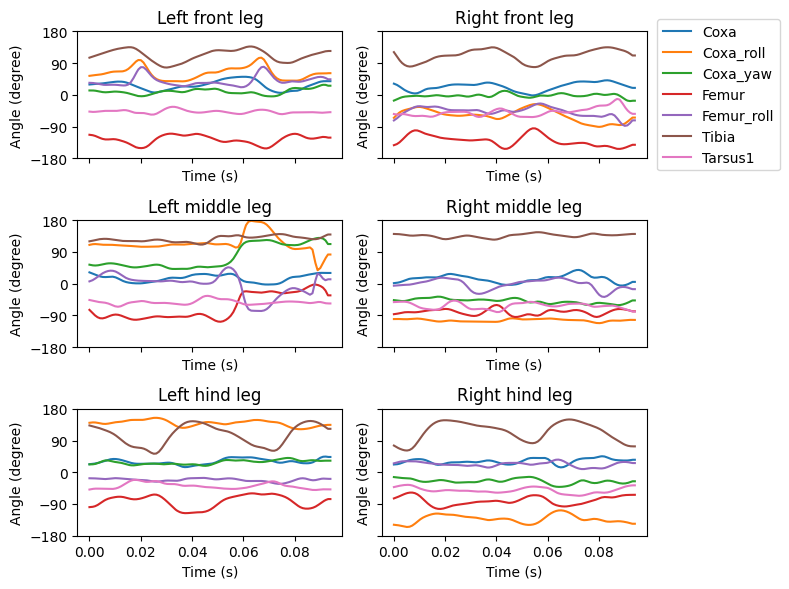

In [6]:
fig, axs = plt.subplots(
    3, 2, figsize=(8, 6), sharex=True, sharey=True, tight_layout=True
)
legs = [
    f"{side} {pos} leg"
    for pos in ["front", "middle", "hind"]
    for side in ["Left", "Right"]
]
for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    leg_code = f"{leg.split()[0][0]}{leg.split()[1][0]}".upper()
    for j, dof in enumerate(actuated_joints):
        if dof.split("_")[1][:2] != leg_code:
            continue
        ax.plot(output_t, np.rad2deg(data_block[j, :]), label=dof[8:])
    ax.set_ylim(-180, 180)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (degree)")
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_title(leg)
    if leg == "Right front leg":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

Path("outputs/").mkdir(exist_ok=True)
fig.savefig("outputs/single_step.png")

In [7]:
# The fly should walk more on the tippy toes
tarsus_offset = np.zeros(len(actuated_joints))
for i, joint in enumerate(actuated_joints):
    if "Tarsus" in joint:
        data_block[i, :] = -1*np.pi/5

Now we can create a NeuroMechFly simulation instance and play out the recorded kinematics in the MDP loop:

In [8]:
nmf = flygym.mujoco.NeuroMechFly(
    sim_params=sim_params,
    init_pose="stretch",
    actuated_joints=actuated_joints,
    control="position",
)

n_steps_stab = 2000

obs, info = nmf.reset()
# stabilise the fly
for i in range(n_steps_stab):
    joint_pos = data_block[:, 0]/max(1, (n_steps_stab/100-i))
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

#obs, info = nmf.reset()
for i in trange(target_num_steps):
    # here, we simply use the recorded joint angles as the target joint angles
    joint_pos = data_block[:, i]        
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()
nmf.save_video(f"videos/single_step.mp4", stabilization_time=0.0)

100%|██████████| 9400/9400 [00:11<00:00, 813.00it/s]


# Basic looping

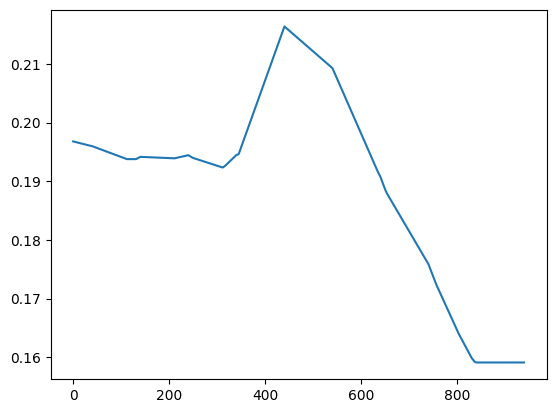

(42, 83121)

In [9]:
# Look where to crop the data_block (two steps)
# Search for maximal closure (eg min diff in angle with respect to the first step) in the n_last_steps
n_init_timepoints = len(data_block[0, :])
n_last_steps = int(np.ceil(0.1*n_init_timepoints))
closure = np.mean(np.abs(data_block[:, -n_last_steps:] - np.tile(data_block[:, 0], (n_last_steps, 1)).T), axis=0)
plt.plot(closure)
plt.show()
# Find the index of the min closure
idx_min_closure = np.argmin(closure)
# Crop the data_block_base
data_block_cropped = data_block[:, :-(n_last_steps+idx_min_closure)]
n_steps_cropped = len(data_block_cropped[0, :])

data_interp_extension_percent = 0.05
n_steps_extension = int(np.floor(n_steps_cropped * data_interp_extension_percent))
n_loops = 10

data_block_interp = np.zeros((len(actuated_joints), n_steps_cropped+n_steps_extension))
# interpolate between the first and last point of data_block_base for every joint
data_block_interp[:, :n_steps_cropped] = data_block_cropped
for j in range(len(actuated_joints)):
    data_block_interp[j, n_steps_cropped:] = np.interp(np.arange(n_steps_extension), [0, n_steps_extension-1], data_block_cropped[j, [-1, 0]])

# Now lets loop this 
data_block_looped = np.tile(data_block_interp, (1, n_loops+1))
half_cycle = int((target_num_steps+n_steps_extension)/2)
data_block_looped = data_block_looped[:, half_cycle:]
target_num_steps_looped = len(data_block_looped[0, :])
data_block_looped.shape

In [10]:
# Though this will not be great as closure in angle space is ill defined as inverse kinematics is underconstrained

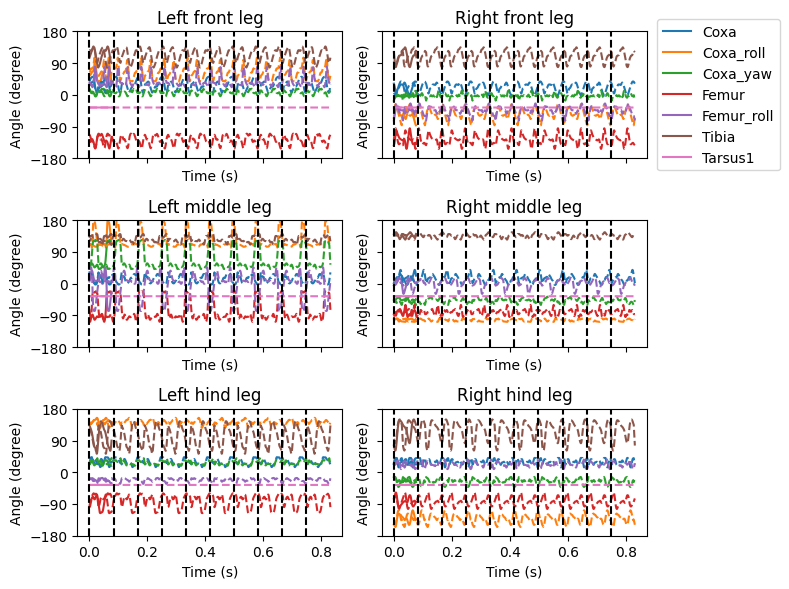

In [11]:
# plot the looped data
fig, axs = plt.subplots(
    3, 2, figsize=(8, 6), sharex=True, sharey=True, tight_layout=True
)
legs = [
    f"{side} {pos} leg"
    for pos in ["front", "middle", "hind"]
    for side in ["Left", "Right"]
]

looped_t = np.arange(data_block_looped.shape[1]) * sim_params.timestep
cropped_t = np.arange(data_block_cropped.shape[1]) * sim_params.timestep

for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    leg_code = f"{leg.split()[0][0]}{leg.split()[1][0]}".upper()
    for j, dof in enumerate(actuated_joints):
        if dof.split("_")[1][:2] != leg_code:
            continue
        ax.plot(cropped_t, np.rad2deg(data_block_cropped[j, :]), label=dof[8:])
    ax.set_prop_cycle(None)  # reset color cycle
    for j, dof in enumerate(actuated_joints):
        if dof.split("_")[1][:2] != leg_code:
            continue
        ax.plot(looped_t, np.rad2deg(data_block_looped[j, :]), linestyle="--")
    for k in range(n_loops):
        ax.axvline(x=looped_t[k*(target_num_steps_looped//10)], color="k", linestyle="--")
    ax.set_ylim(-180, 180)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (degree)")
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_title(leg)
    if leg == "Right front leg":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

Path("outputs/").mkdir(exist_ok=True)
fig.savefig("outputs/basic_looped_single_step.png")

In [12]:
nmf = flygym.mujoco.NeuroMechFly(
    sim_params=sim_params,
    init_pose="stretch",
    actuated_joints=actuated_joints,
    control="position",
)

n_steps_stab = 2000
sim_params.actuator_gain = 75.0


obs, info = nmf.reset()
# stabilise the fly
for i in range(n_steps_stab):
    joint_pos = data_block_looped[:, 0]/max(1, (n_steps_stab/100-i))
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

#obs, info = nmf.reset()
for i in trange(target_num_steps_looped):
    # here, we simply use the recorded joint angles as the target joint angles
    joint_pos = data_block_looped[:, i]        
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()
nmf.save_video(f"videos/basic_looped_single_step.mp4", stabilization_time=0.0)

100%|██████████| 83121/83121 [01:40<00:00, 828.19it/s]
